# Grover's Search Algorithm

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/introduction/grovers-search-algorithm

## Search problems

Many problems that computers are used to solve are _search problems_. For example, given a database, we want to use that database such that given a query input, we want the data associated with that input. It is sort of like a lookup function but we don't always know how they work; they're considered black boxes and we just assume they always work. For this reason, we call them sometimes "oracles".

An example type of search is a _binary search_ and this occurs when we are looking up information for inputs that are sorted by their keys in some alphanumeric way. This is done by checking the middle of the list and if its after your desired input key, we search the top half; otherwise we search the bottom half. Then we look at the center of that half and see whether the desired input key would be sorted above or below; and we keep halving our search space until we find our entry. This shrinks our input space by half, or exponentially, for each iteration which means it works very efficiently in just a classical way.

However, lets say we're instead given a value and need to look up the key. The problem is that our database does not have the entires sorted by value; they are sorted by key. Therefore, we loose the ability to search like we did above and the time it takes to search for our input grows linearly with the number of entries as we have to randomly try on average half of them to find the desired one. <font color=orange>When a database is disordered like this, it is known as **unstructured**.</font>

However in quantum computing, there exists a search algorithm that grows with the square root of the number of inputs, which is a quadratic improvement over the best classical algorithm.

## Beyond black boxes

Search algorithms can be applied to any problems that can be made to _look_ like a database search problem. For example, consider a soduku puzzle. To check if it is solved, you check each row, each column, and each square. In a sense, _you_ are the database and the person having you verify the solution is valid is querying you. So in some ways, its a database or a function that can map an input to an output. In this case, there are many computational problems we can frame that way. One such example problem is the Boolean satisfiability problem (known as SAT).

## SAT problems

SAT problems are very common in computer science and in this page, we'll use Grover's algorithm to solve a simple SAT problem. The solution to such a problem ends up being a string of bits and the problem is a set of conditions (clauses). For 3 bits, a clause might be "you can't have the zeroth bit ON _and_ the first bit OFF" which eliminates 101 and 001 (q0 being far right and q1 as middle). 

We can encode a 3-SAT problem which specifies a set of clauses for a 3-bit solution in a file called a dimacs file. We can use Qiskit's built-in tool to build a circuit that checks if a query string obeys our clauses defined by the dimacs file.

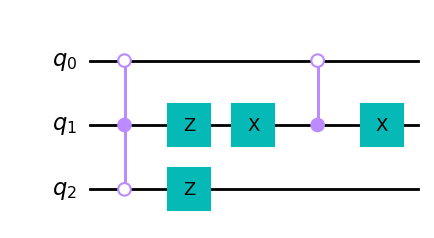

In [8]:
import tempfile
from qiskit.circuit.library import PhaseOracle

with tempfile.NamedTemporaryFile(suffix='.dimacs') as fp:
    fp.write(b"c example DIMACS-CN 3-SAT\np cnf 3 5\n-1 -2 -3 0\n1 -2 3 0\n1 2 -3 0\n1 -2 -3 0\n-1 2 3 0")
    fp.seek(0)
    oracle = PhaseOracle.from_dimacs_file(fp.name)

oracle.draw()

The above circuit tells us whether our query string meets all the clauses or not (True or False) and operates similar to our notion of a "database" as described above. But in order to use this circuit/database with Grover's algorithm, we want the oracle to change the phase of the output by 180 _if_ the state is a solution. So:


$U_{oracle}|x> = |x>$ if $x$ is not a solution, $-|x>$ if $x$ is a solution

and is the equivalent of the identify matrix with the 1 in the jth column negative if the ith row is a solution. We then can use Grover's algorithm to identify which states have their phases changed.

## Overview of Grover's algorithm

Grover's algorithm has 3 steps:

1. Create an equal superposition of every possible input to the oracle. This can be done by applying an H-gate to each qubit and this state is known as |s>.

2. Run the oracle circuit ($U_{oracle}$) on these qubits.

3. Run a circuit called the _diffusion operator_, or _diffuser_ ($U_s$) on the qubits.

Then repeat steps 2 and 3 a few times depending on the size of the circuit. For our case, it small enough that we can just do it once. Below is the circuit build out for steps 1-3 where we reuse our `oracle` circuit above  for step 2.

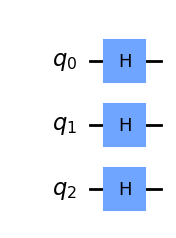

In [9]:
from qiskit import QuantumCircuit
init = QuantumCircuit(3)
init.h([0,1,2])
init.draw()

In [10]:
# steps 2 & 3 of Grover's algorithm
from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)

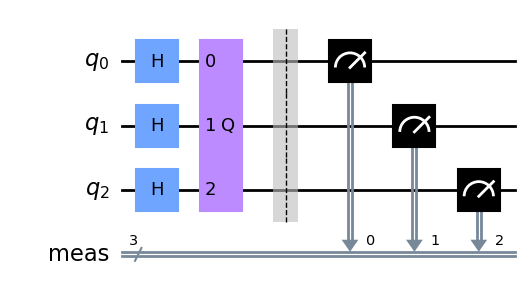

In [11]:
qc = init.compose(grover_operator)
qc.measure_all()
qc.draw()

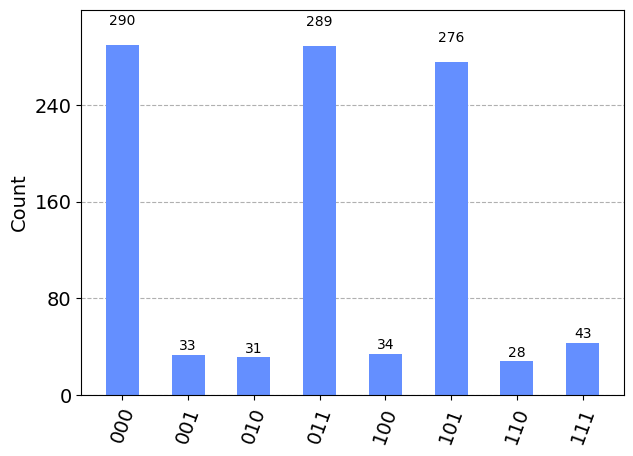

In [12]:
# Simulate the circuit
from qiskit import Aer, transpile
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts)

Here we have measured the 3 solutions to the SAT problem: 000, 011, and 101.

## How does Grover's algorithm work?

Let's consider the following states:

$|R> = \frac{1}{\sqrt{3}}(|000> + |011> + |101>)$

$|W> = \frac{}{\sqrt{5}}(|001> + |010> + |100> + |110> + |111>)$

where |R> is a superposition of the right answers and |W> is a superposition of the wrong answers.

Since the two states don't share any elements, they are perpendicular and thus we can draw them at right angles on a 2D plane, say x (W) and y (R). 

At the beginning of our algorithm, we have state |s> which is a superposition of |R> and |W> since it contains some solutions and some non-solutions. In most cases, there are a lot of possible inputs but only a small number of solutions; thus we would expect our vector to be much closer to the |W> axis than the |R> axis meaning a >> b. 

$|s> = a*|W> + b*|R>$

Once we pass our qubits through the circuit $U_{oracle}$, it flips the phase of all solution states. This now flips the sign of our vector as projected onto our |R> axis. Mathematically, we now have:

$|s'> = a*|W> - b|R>$


The diffuser operator then has the state vector reflect about the s vector, meaning we now get the following:

$|s'> = a'*|W> + b'|R>$

where b' > b. Steps 2 & 3 may need to be repeated a few times to get |s'> as close to the |R> axis as possible but will then lead to the solutions that have the highest probability of being correct.

## Circuits for Grover's algorithm

Our oracle circuit will work on a 2-qubit system and will simply flip the phase of only the state |11>. This is exactly what just a CZ gate does, so we'll implement that. Remember that CZ gate works by applying the `z` gate on the target only if the control is in state |1>; however, the `z` gate does nothing on state |0> so we only see an effect if we have the state |11>.

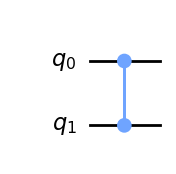

In [45]:
oracle = QuantumCircuit(2)

oracle.cz(0,1)  # invert phase of |11>

oracle.draw()

Below is function to show the matrix representation of this circuit. Its exactly as we described above: the identity matrix except the sign is flipped at ij where i=j=11.

In [52]:
def display_unitary(qc, prefix=""):
    """Simulates a simple circuit and display its matrix representation.
    Args:
        qc (QuantumCircuit): The circuit to compile to a unitary matrix
        prefix (str): Optional LaTeX to be displayed before the matrix
    Returns:
        None (displays matrix as side effect)
    """
    from qiskit import Aer
    from qiskit.visualization import array_to_latex
    sim = Aer.get_backend('aer_simulator')
    # Next, we'll create a copy of the circuit and work on
    # that so we don't change anything as a side effect
    qc = qc.copy()
    # Tell the simulator to save the unitary matrix of this circuit
    qc.save_unitary()
    unitary = sim.run(qc).result().get_unitary()
    display(array_to_latex(unitary, prefix=prefix))

display_unitary(oracle, "U_\\text{oracle}=")

<IPython.core.display.Latex object>

Next is our diffuser. We want something that can apply a negative phase or a reflection about the state |s>. Since we were able to do this with a `cz` gate for the state |11>, then we should be able to do the same by:

1. Transform |s> --> |11>
2. Reflect around |11>
3. Transform |11> --> |s>

We know that our initial |s> is the superposition of all possible inputs, so we can undo that superposition by applying the H-gate on both qubits to get us to |00>. But we want |11> not |00>, so we'll apply an `x` gate to both qubits as well.

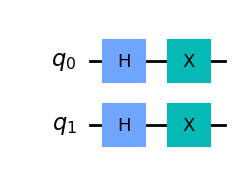

In [48]:
diffuser = QuantumCircuit(2)

# apply H-gates to both qubits to convert |s> --> |00>
diffuser.h([0, 1])

# apply x-gates to both quibits to convert |00> --> |11>
diffuser.x([0,1])

diffuser.draw()

Now, we have step 1 done we can apply our `cz` gate for step 2 and then undo our transformation from step 1 in step 3.

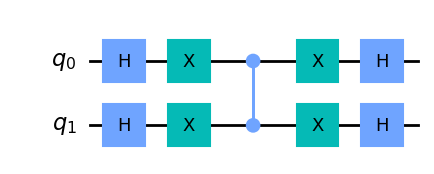

In [49]:
diffuser.cz(0,1)
diffuser.x([0,1])
diffuser.h([0,1])
diffuser.draw()

So now that we have our oracle and diffuser, we can put it all together following the 3 steps of Grover's algorithm as described above.

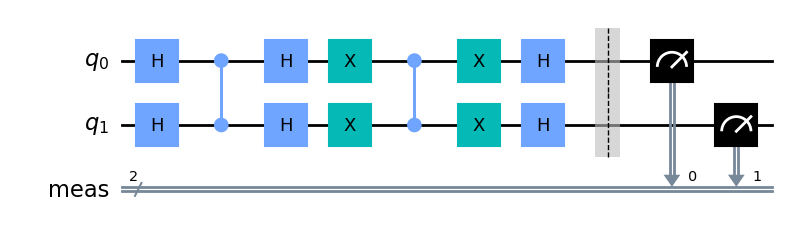

In [50]:
grover = QuantumCircuit(2)
grover.h([0,1])  # step 1) initialise |s>
grover = grover.compose(oracle) # step 2) apply oracle
grover = grover.compose(diffuser) # step 3) apply diffuser
grover.measure_all()
grover.draw()

In [51]:
from qiskit import Aer
sim = Aer.get_backend('aer_simulator')
sim.run(grover).result().get_counts()

{'11': 1024}

And indeed we get back the value we were expecting.

<font color=red>Question:</font> How does the qiskit `PhaseOracle.from_dimacs_file` method work and if it creates a circuit that can implement the matrix with negative phases for the solutions then do we even need to run the circuit at all? Or can we take the circuit operations, do the linear algebra to compute the $U_{oracle}$ matrix and check the columns that have -1's? In other words, is the encoding of the problem the solution itself rather than Grover's algorithm of superposition _+ oracle + diffuser?

## SAT problems are hard

Originally, we stated that randomly guessing solutions grows linear with the number of entries in a database. But we usually measure algorithm complexity by their input length in _bits_. Each additional bit in our SAT problem _doubles_ the number of possible solutions so the search space grows exponentially as a function of the length.

## Making use of structure

There is a classical algorithm called Schoning's algorithm that can actually outperform Grover's. It works by first choosing an input at random and checking if it works. If it doesn't, then it picks a clause and toggles a bit to satisfy that clause. This may cause another condition to now be broken but it continues to toggle until it finds a satisfactory input string. If the intially random guess was close enough, it will find a correct solution but if not, after some number of steps, it will start with a completely new random guess.

<font color=red>Question:</font> Does Schoning's algorithm find only 1 solution? How does this compare to Grover's, which finds all solutions?

Furthermore, Grover and Schoning's algorithms can be combined to get an even faster solution that looks like a component that carries out Schoning's algorithm (bit toggling) and use this as the oracle and with Grover's algorithm, find the best "initial guess". 